In [ ]:
USER INPUT
   ↓
llm_router
   ↓
agent_choice →────────────┐
                          │
   ┌────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┐
   ↓                                                            ↓                                                            ↓                                                            ↓
agent_summ                                                general_agent                                               loan_agent                                                  mail_agent
   │                                                            │                                                            │                                                            │
   ↓                                                            ↓                                                            ↓                                                            ↓
cypher_query_and_retrieve_node                                   cypher_query_and_retrieve_node                                   cypher_query_and_retrieve_node                                   cypher_query_and_retrieve_node
   ↓                                                            ↓                                                            ↓                                                            ↓
neo4j_retriever                                           neo4j_retriever                                           neo4j_retriever                                           neo4j_retriever
   ↓                                                            ↓                                                            ↓                                                            ↓
review_reflector? (optional retry loop)                      (skip)                                                       (skip)                                                       (skip)
   ↓                                                            ↓                                                            ↓                                                            ↓
agent_summ                                                general_agent                                               loan_agent (→ call loan approval API)                      mail_content_generator (LLM-based)
   ↓                                                            ↓                                                            ↓                                                            ↓
                                                           final response                                             justification (LLM-generated)                                send_mail (loop over customers)
                                                                                                                             ↓                                                            ↓
                                                                                                                             END                                                         END


In [2]:
# --- Imports ---
from langgraph.graph import StateGraph
from langgraph.graph.message import MessageGraph
from typing import TypedDict, List, Literal, Dict, Optional
from langchain_core.runnables import Runnable
from langchain_core.messages import AIMessage, HumanMessage
from operator import itemgetter

In [3]:
# --- State Definition ---
class AgentState(TypedDict):
    user_input: str
    agent_choice: Optional[str]
    neo4j_query: Optional[str]
    neo4j_result: Optional[List[Dict]]
    api_response: Optional[Dict]
    final_response: Optional[str]
    error: Optional[str]

In [4]:
# --- Placeholder Tools & LLMs ---
llm = ...  # Your LLM instance
def neo4j_tool(query): ...  # Your Neo4j DB executor
def send_mail_tool(email, content): ...  # Your SMTP or API sender
def loan_approval_api(customer_data): ...  # External loan decision service

In [18]:


# --- Core Nodes ---
def llm_router(state: AgentState):
    prompt = f"""Decide which agent to route the following query to:
    "{state['user_input']}"
    Options: agent_summ, general_agent, loan_agent, mail_agent
    """
    agent_choice = llm.invoke(prompt).strip().lower()
    return {"agent_choice": agent_choice}

def cypher_query_and_retrieve_node(state: AgentState):
    prompt = f"""Generate a Cypher query for this request:
    "{state['user_input']}"
    """
    query = llm.invoke(prompt).strip()
    return {"neo4j_query": query}


def review_reflector(state: AgentState):
    if state.get("error"):
        # Retry query generation
        return cypher_query_and_retrieve_node(state)
    return {}

def agent_summ(state: AgentState):
    reviews = state["neo4j_result"]
    prompt = f"""Summarize and suggest improvements based on these reviews:
    {reviews}
    """
    response = llm.invoke(prompt)
    return {"final_response": response}

def general_agent(state: AgentState):
    context = state["neo4j_result"]
    prompt = f"""Based on this data, respond to the query:
    Query: {state['user_input']}
    Data: {context}
    """
    response = llm.invoke(prompt)
    return {"final_response": response}

def loan_agent(state: AgentState):
    customer_data = state["neo4j_result"]
    api_result = loan_approval_api(customer_data)
    prompt = f"""Given:
    Customer: {customer_data}
    API Result: {api_result}
    Generate a decision explanation.
    """
    response = llm.invoke(prompt)
    return {"api_response": api_result, "final_response": response}

# --- Mail Agent Branching ---
def mail_intent_classifier(state: AgentState):
    prompt = f"""Classify the intent of this mail request:
    "{state['user_input']}"
    Reply with one of: 'min_balance', 'product_ad'
    """
    result = llm.invoke(prompt).strip().lower()
    return result

def generate_min_balance_email(state: AgentState):
    customers = state["neo4j_result"]
    emails = []
    for cust in customers:
        prompt = f"""
        Write a balance alert email to:
        Name: {cust['name']}, Email: {cust['email']}
        """
        content = llm.invoke(prompt)
        emails.append({"email": cust["email"], "content": content})
    return {"emails_to_send": emails}

def generate_product_ad_email(state: AgentState):
    customers = state["neo4j_result"]
    emails = []
    for cust in customers:
        prompt = f"""
        Write a promotional email to:
        Name: {cust['name']}, Email: {cust['email']}
        """
        content = llm.invoke(prompt)
        emails.append({"email": cust["email"], "content": content})
    return {"emails_to_send": emails}

def send_mail(state: AgentState):
    for email_data in state["emails_to_send"]:
        send_mail_tool(email_data["email"], email_data["content"])
    return {"final_response": "Emails sent successfully."}

# --- Build Graph ---
workflow = StateGraph(AgentState)
workflow.set_entry_point("llm_router")

# Add nodes
workflow.add_node("llm_router", llm_router)
workflow.add_node("cypher_query_and_retrieve_node", cypher_query_and_retrieve_node)
#workflow.add_node("neo4j_retriever", neo4j_retriever)

workflow.add_node("review_reflector", review_reflector)
workflow.add_node("agent_summ", agent_summ)
workflow.add_node("general_agent", general_agent)
workflow.add_node("loan_agent", loan_agent)
workflow.add_node("mail_intent_classifier", mail_intent_classifier)
workflow.add_node("generate_min_balance_email", generate_min_balance_email)
workflow.add_node("generate_product_ad_email", generate_product_ad_email)
workflow.add_node("send_mail", send_mail)

# Add core routing logic
workflow.add_conditional_edges("llm_router", lambda s: s["agent_choice"], {
    "agent_summ": "review_reflector",
    "general_agent": "cypher_query_and_retrieve_node",
    "loan_agent": "cypher_query_and_retrieve_node",
    "mail_agent": "cypher_query_and_retrieve_node"
})

# # Shared data retrieval
# workflow.add_edge("cypher_query_and_retrieve_node", "neo4j_retriever")

# Summarization agent with reflector retry
workflow.add_conditional_edges("cypher_query_and_retrieve_node", lambda s: s.get("agent_choice"), {
    "general_agent": "general_agent",
    "loan_agent": "loan_agent",
    "mail_agent": "mail_intent_classifier"
})
workflow.add_edge("review_reflector", "agent_summ")

# Mail intent split
workflow.add_conditional_edges("mail_intent_classifier", mail_intent_classifier, {
    "min_balance": "generate_min_balance_email",
    "product_ad": "generate_product_ad_email"
})
workflow.add_edge("generate_min_balance_email", "send_mail")
workflow.add_edge("generate_product_ad_email", "send_mail")

# Set final output point
workflow.set_finish_point("send_mail")
workflow.set_finish_point("agent_summ")
workflow.set_finish_point("general_agent")
workflow.set_finish_point("loan_agent")

# Compile it
graph = workflow.compile()


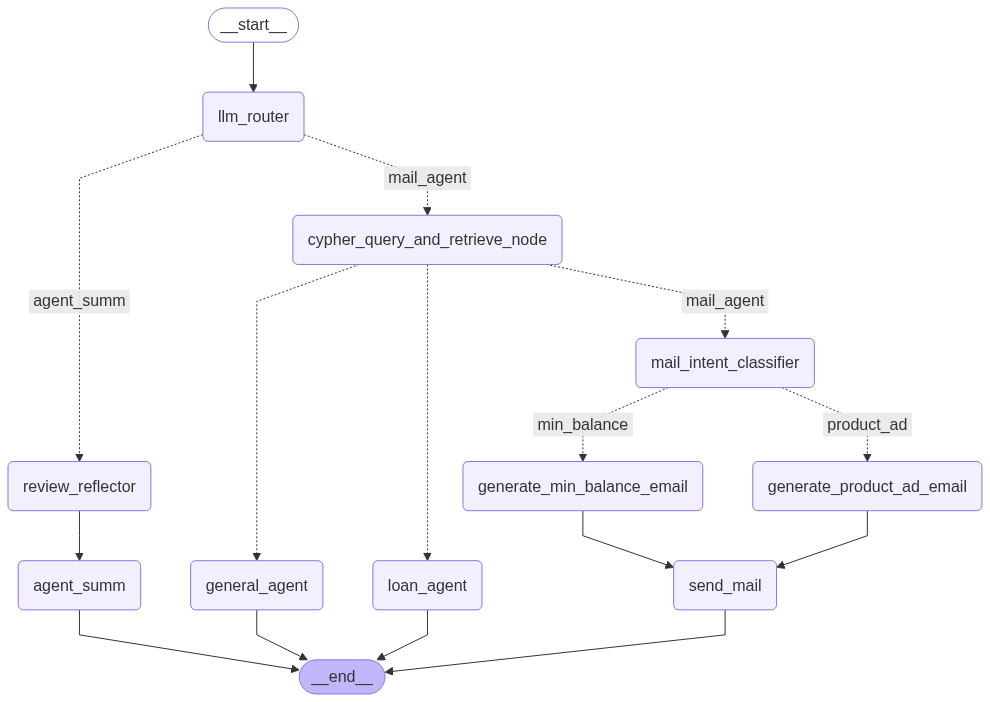

In [19]:
# View
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

“Why not remove the first conditional at llm_router, and instead, always go to cypher_query_and_retrieve_node → neo4j_retriever, and only apply conditional routing after data is retrieved?”

🤔 Are There Any Drawbacks?
Only one minor point:

If in the future, some agents don’t require Neo4j, then forcing every query through cypher_query_and_retrieve_node → neo4j_retriever may become inefficient.

In [ ]:
uv pip install python-dotenv langchain-groq langchain langchain_community langchain_neo4j openai pyyaml secure-smtplib sendgrid -q 

In [42]:
uv pip install sendgrid -q

Note: you may need to restart the kernel to use updated packages.


In [20]:
# --- State Definition ---
class AgentState(TypedDict):
    user_input: str
    agent_choice: agent_summ
    neo4j_query: Optional[str]
    neo4j_result: Optional[List[Dict]]
    api_response: Optional[Dict]
    final_response: Optional[str]
    error: Optional[str]

NameError: name 'TypedDict' is not defined

In [ ]:
def llm_router(state: AgentState):
    prompt = f"""Decide which agent to route the following query to:
    "{state['user_input']}"
    Options: agent_summ, general_agent, loan_agent, mail_agent
    """
    agent_choice = llm.invoke(prompt).strip().lower()
    return {"agent_choice": agent_choice}

In [ ]:
def cypher_query_and_retrieve_node(state: AgentState):
    prompt = f"""Generate a Cypher query for this request:
    "{state['user_input']}"
    """
    query = llm.invoke(prompt).strip()
    return {"neo4j_query": query}

In [7]:
import yaml
# Load prompts from YAML file
def load_prompts(yaml_file_path: str):
    with open(yaml_file_path, 'r') as file:
        return yaml.safe_load(file)

# Load all prompts
prompts_dict = load_prompts("prompts.yaml")

# Example: Use cypher_generation prompt
cypher_prompt_text = prompts_dict["cypher_generation"]["template"]


In [28]:
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain_neo4j import Neo4jGraph

# Load your environment variables
import os
from dotenv import load_dotenv
load_dotenv()

graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
)

llm = ChatGroq(
    model_name="llama3-8b-8192",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0,
)

prompt = PromptTemplate(
    input_variables=["schema", "question"],
    template= cypher_prompt_text
)

def generate_and_run(question: str):
    schema = graph.schema  
    #print(schema)
    prompt_text = prompt.format(schema=schema, question=question)
    cypher_query = llm.invoke(prompt_text).content
    result = graph.query(cypher_query)
    return {"cypher": cypher_query, "result": result}



In [31]:
#q = "Which customer has written the most reviews?"
q = "which customer is having minimum account balance"
q = "list all reviews"

In [32]:
response = generate_and_run(q)
print("Generated Cypher:", response["cypher"])
print("Neo4j Result:", response["result"])


Generated Cypher: MATCH (r:Review)
RETURN r.review AS review
Neo4j Result: [{'review': 'State Bank Of India is located nearby in our area so i open my saving account from that bank ,customer service was good, I got my bank statement on time the bank agent informed me every details required. It is very easy and convenience for money deposits.'}, {'review': 'I have my salary account in SBI, when I applied for the card I got my statement on time. I am very much satisfied with the the account. Net banking is also functioning smooth and convenient for me. There are some offer in the cards which was good.'}, {'review': "I am using savings account from SBI more than 4 years. If i don't keep any balance, they are deducting some amount so i am  keep on  maintaining the amount. I am doing all transactions and EMI transfer I am using this account only. Customer service was okay."}, {'review': 'My mother has suggested SBI to open a saving account with them. Since she is govt employee, know all ben

In [35]:
len(response["result"])

300

In [11]:
def agent_summ(state: AgentState):
    reviews = state["neo4j_result"]
    prompt = f"""Summarize and suggest improvements based on these reviews:
    {reviews}
    """
    response = llm.invoke(prompt)
    return {"final_response": response}

In [33]:
def agent_summ(review): 
    prompt = f"""Summarize and suggest improvements based on these reviews:
{review}
"""
    response = llm.invoke(prompt)
    return {"final_response": response.content}


In [37]:
response["result"][:5]

[{'review': 'State Bank Of India is located nearby in our area so i open my saving account from that bank ,customer service was good, I got my bank statement on time the bank agent informed me every details required. It is very easy and convenience for money deposits.'},
 {'review': 'I have my salary account in SBI, when I applied for the card I got my statement on time. I am very much satisfied with the the account. Net banking is also functioning smooth and convenient for me. There are some offer in the cards which was good.'},
 {'review': "I am using savings account from SBI more than 4 years. If i don't keep any balance, they are deducting some amount so i am  keep on  maintaining the amount. I am doing all transactions and EMI transfer I am using this account only. Customer service was okay."},
 {'review': 'My mother has suggested SBI to open a saving account with them. Since she is govt employee, know all benefits and details. Hence I am having an account with them past 7 years. 

In [38]:
agent_summ(response["result"][:50])

{'final_response': "**Summary:**\n\nThe reviews of State Bank of India (SBI) customers are generally positive, with many praising the bank's convenient services, user-friendly mobile app, and good customer service. Some common themes include:\n\n* Convenience: Many customers appreciate the bank's wide network of branches and ATMs, making it easy to access their accounts and conduct transactions.\n* User-friendly services: The mobile app and internet banking services are praised for their ease of use and convenience.\n* Good customer service: Many customers report positive experiences with the bank's customer service, including responsive and helpful staff.\n* Competitive interest rates: Some customers mention that the bank offers competitive interest rates, which is a major factor in their decision to choose SBI.\n\nHowever, some customers also mention some drawbacks, such as:\n\n* Minimum balance requirements: Many customers are required to maintain a minimum balance in their accounts

{'final_response': "**Summary:**\n\nThe reviews of State Bank of India (SBI) customers are generally positive, with many praising the bank's convenient services, user-friendly mobile app, and good customer service. Some common themes include:\n\n* Convenience: Many customers appreciate the bank's wide network of branches and ATMs, making it easy to access their accounts and conduct transactions.\n* User-friendly services: The mobile app and internet banking services are praised for their ease of use and convenience.\n* Good customer service: Many customers report positive experiences with the bank's customer service, including responsive and helpful staff.\n* Competitive interest rates: Some customers mention that the bank offers competitive interest rates, which is a major factor in their decision to choose SBI.\n\nHowever, some customers also mention some drawbacks, such as:\n\n* Minimum balance requirements: Many customers are required to maintain a minimum balance in their accounts, which can be a challenge for those with limited funds.\n* Hidden charges: Some customers report being charged unexpected fees or penalties, which can be frustrating.\n* Slow response times: A few customers mention that the bank's customer service can be slow to respond to their queries or issues.\n\n**Suggestions for Improvement:**\n\n1. **Simplify minimum balance requirements**: Consider offering more flexible minimum balance requirements or waiving them for certain accounts to make it easier for customers to manage their finances.\n2. **Transparency on fees and charges**: Clearly communicate all fees and charges to customers upfront, and ensure that they are not surprised by unexpected charges.\n3. **Improve customer service response times**: Invest in technology and training to ensure that customer service representatives can respond quickly and efficiently to customer queries and issues.\n4. **Enhance mobile app and internet banking services**: Continuously update and improve the mobile app and internet banking services to ensure they remain user-friendly and convenient for customers.\n5. **Offer more competitive interest rates**: Consider offering more competitive interest rates to attract and retain customers, especially in a competitive banking market.\n\nOverall, SBI has a strong reputation and many satisfied customers, but there are areas where the bank can improve to better meet the needs of its customers."}

In [39]:
def send_mail(state: AgentState):
    for email_data in state["emails_to_send"]:
        send_mail_tool(email_data["email"], email_data["content"])
    return {"final_response": "Emails sent successfully."}

In [53]:
import smtplib
from email.mime.text import MIMEText

# Email credentials
sender_email = "pdrudra.121@gmail.com"
recipient_email = "amitkumar6564422@gmail.com"
app_password = "svij fcje mylm igsr"  # Replace with Gmail App Password

# Email content
subject = "Ping Test from SBI"


python_code = '''
import smtplib
from email.mime.text import MIMEText

# Email credentials
sender_email = "pdrudra.121@gmail.com"
recipient_email = "amitkumar6564422@gmail.com"
app_password = "svij fcje mylm igsr"  # Replace with Gmail App Password

# Email content
subject = "Ping Test from SBI"
body = "Hello Rudra, this is a test email from SBI's system."

# Compose email
msg = MIMEText(body, "plain")
msg["Subject"] = subject
msg["From"] = sender_email
msg["To"] = recipient_email

# Send the email
try:
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, recipient_email, msg.as_string())
    print("✅ Email sent successfully!")
except Exception as e:
    print(f"❌ Failed to send email: {str(e)}")
'''


body  = f"Here is the Python code:\n\n```python\n{python_code}\n```"

# Compose email
msg = MIMEText(body, "plain")
msg["Subject"] = subject
msg["From"] = sender_email
msg["To"] = recipient_email

# Send the email
try:
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, recipient_email, msg.as_string())
    print("✅ Email sent successfully!")
except Exception as e:
    print(f"❌ Failed to send email: {str(e)}")


✅ Email sent successfully!
